In [ ]:
pip install pandas numpy scikit-learn tqdm torch geneticalgorithm

In [19]:
# ---------------------- Importing Packages ---------------------- #
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from geneticalgorithm import geneticalgorithm as ga
import random

# ---------------------- Reproducibility ---------------------- #
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# Select CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------- Fold Configuration Settings ---------------------- #
sequence_length = 252
val_window_num_sequences = 252
holdout_base = 756
forecast_horizons = [1, 5, 21, 63, 252]

# ---------------------- Genetic Algorithm Search Space ---------------------- #
batch_size_options = [16, 32, 64, 128]
hidden_dim_range = (32, 128)
num_layers_options = [1, 2]
dropout_range = (0.1, 0.5)
learning_rate_range = (1e-4, 1e-2)
num_epochs = 20
patience = 10

# ---------------------- LSTM Classifier ---------------------- #
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.0):
        super().__init__()
        effective_dropout = dropout if num_layers > 1 else 0.0
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=effective_dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# ---------------------- Helper: Sequence Creation ---------------------- #
def create_sequences(X_df, Y_df, seq_len, forecast_horizon):
    X_seq, Y_seq = [], []
    X_arr = X_df.values.astype(np.float32)
    Y_arr = Y_df.values.astype(np.float32)
    for i in range(len(X_arr) - seq_len - forecast_horizon + 1):
        X_seq.append(X_arr[i:i + seq_len])
        Y_seq.append(Y_arr[i + seq_len + forecast_horizon - 1])
    return np.array(X_seq), np.array(Y_seq)

# ---------------------- Helper: Feature Shifting ---------------------- #
def shift_X_by_horizon(X_df, horizon):
    return X_df.shift(horizon).dropna()

# ---------------------- Helper: Fold Standardization ---------------------- #
def standardize_fold(X_train, X_val):
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
    return X_train_scaled, X_val_scaled

# ---------------------- Generate Expanding Folds ---------------------- #
def get_expanding_folds(X_df, Y_df, forecast_horizon, sequence_length, val_window_num_sequences, holdout_base):
    assert X_df.index.equals(Y_df.index)
    total_days = len(X_df)
    val_window = sequence_length + forecast_horizon + val_window_num_sequences - 1
    min_train_window = sequence_length + forecast_horizon + val_window_num_sequences - 1

    fold_starts = []
    i = min_train_window
    while i + val_window + holdout_base <= total_days:
        fold_starts.append(i)
        i += val_window

    folds = []
    for fold_start in fold_starts:
        train_end = fold_start
        val_start = fold_start
        val_end = fold_start + val_window

        X_train = X_df.iloc[:train_end].copy()
        Y_train = Y_df.iloc[:train_end].copy()
        X_val = X_df.iloc[val_start:val_end].copy()
        Y_val = Y_df.iloc[val_start:val_end].copy()

        folds.append({
            "X_train": X_train,
            "Y_train": Y_train,
            "X_val": X_val,
            "Y_val": Y_val,
            "fold_start": fold_start,
            "fold_end": val_end,
        })

    last_val_end = folds[-1]['fold_end']
    holdout_days = total_days - last_val_end
    print(f"[INFO] Generated {len(folds)} folds for forecast horizon {forecast_horizon}")
    return folds, last_val_end, holdout_days

# ---------------------- Global Objective Function Across All Folds ---------------------- #
def global_objective_function(params, folds, forecast_horizon):
    hidden_dim = int(params[0])
    num_layers = int(params[1])
    dropout = params[2]
    learning_rate = params[3]
    batch_size = int(params[4])

    total_accuracy = 0
    total_folds = len(folds)

    for fold in folds:
        X_train_std, X_val_std = standardize_fold(fold["X_train"], fold["X_val"])
        X_train_seq, Y_train_seq = create_sequences(X_train_std, fold["Y_train"], sequence_length, forecast_horizon)
        X_val_seq, Y_val_seq = create_sequences(X_val_std, fold["Y_val"], sequence_length, forecast_horizon)

        X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
        Y_train_tensor = torch.tensor(Y_train_seq, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
        Y_val_tensor = torch.tensor(Y_val_seq, dtype=torch.float32).to(device)

        model = LSTMClassifier(X_train_seq.shape[2], hidden_dim, num_layers, Y_train_seq.shape[1], dropout).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.BCEWithLogitsLoss()

        train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size)

        best_acc = 0
        patience_counter = 0

        for epoch in range(num_epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()

            model.eval()
            preds = []
            with torch.no_grad():
                for xb, _ in val_loader:
                    preds.append(torch.sigmoid(model(xb)))
            pred_tensor = torch.cat(preds, dim=0).squeeze()
            acc = ((pred_tensor > 0.5).int() == Y_val_tensor.int()).float().mean().item()
            if acc > best_acc:
                best_acc = acc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break

        total_accuracy += best_acc

    return -total_accuracy / total_folds

# ---------------------- Run GA for Global Optimization ---------------------- #
def run_global_genetic_optimization(folds, forecast_horizon):
    varbound = np.array([
        [hidden_dim_range[0], hidden_dim_range[1]],
        [min(num_layers_options), max(num_layers_options)],
        [dropout_range[0], dropout_range[1]],
        [learning_rate_range[0], learning_rate_range[1]],
        [min(batch_size_options), max(batch_size_options)]
    ])

    algorithm_param = {
        'max_num_iteration': 10,
        'population_size': 5,
        'mutation_probability': 0.2,
        'elit_ratio': 0.1,
        'crossover_probability': 0.5,
        'parents_portion': 0.3,
        'crossover_type': 'uniform',
        'max_iteration_without_improv': 5
    }

    model = ga(
        function=lambda x: global_objective_function(x, folds, forecast_horizon),
        dimension=5,
        variable_type='real',
        variable_boundaries=varbound,
        algorithm_parameters=algorithm_param
    )

    model.run()
    return model.best_variable, model.best_function

# ---------------------- Run Optimization for All Horizons ---------------------- #
def run_for_all_horizons(X_df, Y_df_dict):
    all_results = {}
    for h in forecast_horizons:
        print(f"\n=== Forecast Horizon: {h} ===")
        Y_df = Y_df_dict[h]
        X_shifted = shift_X_by_horizon(X_df, h)
        Y_aligned = Y_df.loc[X_shifted.index]
        X_final, Y_final = X_shifted, Y_aligned
        folds, _, _ = get_expanding_folds(X_final, Y_final, h, sequence_length, val_window_num_sequences, holdout_base)
        best_params, best_score = run_global_genetic_optimization(folds, h)
        all_results[h] = {"best_params": best_params, "best_score": best_score}
        print(f"[RESULT] Horizon {h}: Best Params = {best_params}, Best Score = {-best_score:.4f}")
    return all_results

C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# ---------------------- Fold Debugging Script with Holdout Test Info ---------------------- #
import pandas as pd

# Load feature data
X_df = pd.read_csv(r'C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Independent\X_df.csv', index_col=0, parse_dates=True)
X_df.index = pd.to_datetime(X_df.index)

# Configs
sequence_length = 252
holdout_base = 756
forecast_horizons = [1, 5, 21, 63, 252]

# Run diagnostics for each forecast horizon
for h in forecast_horizons:
    print(f"\n=== Forecast Horizon: {h} ===")

    # Load directional labels for the current horizon
    Y_df = pd.read_csv(fr'C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Classification\Y_df_change_dir_{h}.csv', index_col=0, parse_dates=True)
    Y_df.index = pd.to_datetime(Y_df.index)

    # Shift and align
    X_shifted = shift_X_by_horizon(X_df, h)
    common_idx = X_shifted.index.intersection(Y_df.index)
    X_aligned = X_shifted.loc[common_idx]
    Y_aligned = Y_df.loc[common_idx]

    assert X_aligned.index.equals(Y_aligned.index), "Index mismatch after aligning!"

    # Fold generation
    val_window = sequence_length + h + 252 - 1
    folds, last_val_end, holdout_days = get_expanding_folds(X_aligned, Y_aligned, h, sequence_length, val_window, holdout_base)

    print(f"[INFO] Number of folds: {len(folds)}")

    for i, fold in enumerate(folds):
        train_start = fold['X_train'].index[0]
        train_end = fold['X_train'].index[-1]
        val_start = fold['X_val'].index[0]
        val_end = fold['X_val'].index[-1]

        print(f"--- Fold {i+1} ---")
        print(f"Train: {train_start.date()} to {train_end.date()} | {fold['X_train'].shape}")
        print(f"Validation: {val_start.date()} to {val_end.date()} | {fold['X_val'].shape}")
        print(f"---" * 5)

    # Holdout test set range


=== Forecast Horizon: 1 ===


TypeError: 'int' object is not subscriptable

In [ ]:
# Load data
X_df = pd.read_csv(r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Independent\X_df.csv", index_col=0, parse_dates=True)
Y_df_dict = {
    1: pd.read_csv(r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Classification\Y_df_change_dir_1.csv", index_col=0, parse_dates=True),
    5: pd.read_csv(r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Classification\Y_df_change_dir_5.csv", index_col=0, parse_dates=True),
    21: pd.read_csv(r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Classification\Y_df_change_dir_21.csv", index_col=0, parse_dates=True),
    63: pd.read_csv(r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Classification\Y_df_change_dir_63.csv", index_col=0, parse_dates=True),
    252: pd.read_csv(r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Classification\Y_df_change_dir_252.csv", index_col=0, parse_dates=True),
}

# Run optimization
results = run_for_all_horizons(X_df, Y_df_dict)

Adjusted split dates (train/val ends here):
Horizon 1: 2021-10-23
Horizon 5: 2022-01-09
Horizon 21: 2022-11-11
Horizon 63: 2021-09-13
Horizon 252: 2020-07-16


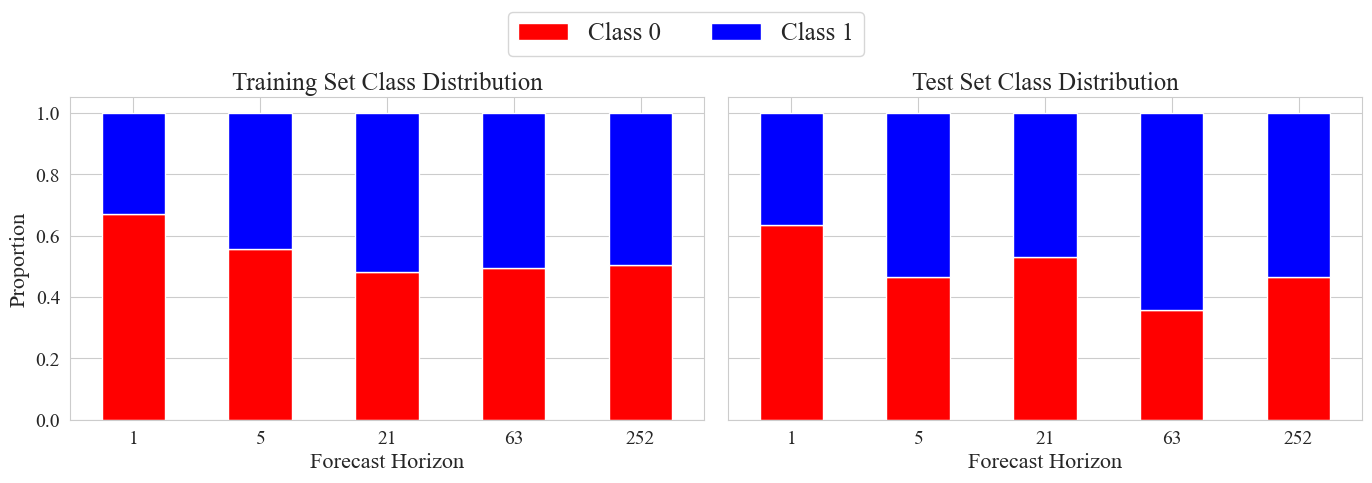

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use Times New Roman

plt.rcParams['font.family']      = 'serif'
plt.rcParams['font.serif']       = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size']        = 16    # a bit larger than default
plt.rcParams['axes.titlesize']   = 18
plt.rcParams['axes.labelsize']   = 16
plt.rcParams['xtick.labelsize']  = 14
plt.rcParams['ytick.labelsize']  = 14
plt.rcParams['legend.fontsize']  = 18

# Horizon-to-file mapping
y_files = {
    1: r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Classification\Y_df_change_dir_1.csv",
    5: r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Classification\Y_df_change_dir_5.csv",
    21: r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Classification\Y_df_change_dir_21.csv",
    63: r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Classification\Y_df_change_dir_63.csv",
    252: r"C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Dependent\Classification\Y_df_change_dir_252.csv"
}

from datetime import timedelta

# Last validation end dates from folds (from your earlier logs)
last_val_end_dates = {
    1: "2021-02-12",
    5: "2021-04-27",
    21: "2022-02-11",
    63: "2020-11-02",
    252: "2019-02-28"
}

# Common configuration
sequence_length = 252

# Adjusted test split cutoff (accounting for sequence + forecast horizon)
split_dates = {}
for horizon, end_date_str in last_val_end_dates.items():
    end_date = pd.to_datetime(end_date_str)
    buffer_days = sequence_length + horizon
    true_cutoff = end_date + pd.Timedelta(days=buffer_days)
    split_dates[horizon] = true_cutoff.strftime("%Y-%m-%d")

# Final result
print("Adjusted split dates (train/val ends here):")
for h, d in split_dates.items():
    print(f"Horizon {h}: {d}")


# (Assume split_dates is defined above)

# Collect class distributions
train_dists, test_dists = {}, {}
for h, path in y_files.items():
    y = pd.read_csv(path, index_col=0, parse_dates=True).iloc[:, 0]
    cutoff = pd.to_datetime(split_dates[h])
    train, test = y[y.index <= cutoff], y[y.index > cutoff]
    train_dists[h] = train.value_counts(normalize=True).reindex([0,1]).fillna(0)
    test_dists[h]  = test.value_counts(normalize=True).reindex([0,1]).fillna(0)

train_df = pd.DataFrame(train_dists).T
test_df  = pd.DataFrame(test_dists).T
train_df.columns = ['Class 0','Class 1']
test_df.columns  = ['Class 0','Class 1']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

train_df.plot(kind='bar', stacked=True, ax=axes[0],
              color=['red','blue'], legend=False)
axes[0].set(title="Training Set Class Distribution",
            xlabel="Forecast Horizon", ylabel="Proportion")
axes[0].tick_params(axis='x', rotation=0)   # no rotation
axes[0].grid(True)

test_df.plot(kind='bar', stacked=True, ax=axes[1],
             color=['red','blue'], legend=False)
axes[1].set(title="Test Set Class Distribution",
            xlabel="Forecast Horizon")
axes[1].tick_params(axis='x', rotation=0)   # no rotation
axes[1].grid(True)

# shared legend, doubled size
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2,
           prop={'size': plt.rcParams['legend.fontsize']})

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()